In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import torchvision
from timm import create_model
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import torch.nn as nn

In [27]:
# Define the transform
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
# Load the pretrained model
classificator = create_model('vgg11_bn.tv_in1k', pretrained=True).eval()

In [16]:
# Define the class index for chicken in ImageNet
chicken_imagenet_class_idx = 8

tensor(0.8525)


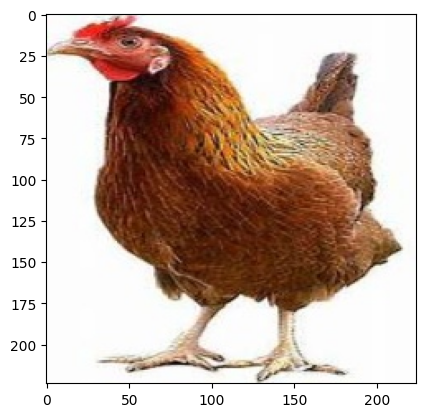

In [17]:
# Load and preprocess the image
SOURCE_IMAGE_PATH = f"/content/drive/MyDrive/DATA1/2.jpeg"
image = Image.open(SOURCE_IMAGE_PATH)

with torch.no_grad():
    logits = classificator(transform(image).unsqueeze(0)).squeeze(0)
    probs = torch.softmax(logits, 0)
    print(probs[chicken_imagenet_class_idx])

plt.imshow(image)
plt.show()

In [18]:
# Get all image paths
paths = [path for path in Path('/content/drive/MyDrive/DATA1/gallina').rglob('*.jpeg')]

In [19]:
# Function to fuse batch normalization layers
def fuse_bn(module):
    module_output = module
    if isinstance(module, nn.Sequential):
        for idx in range(len(module) - 1):
            if isinstance(module[idx], nn.Conv2d) and isinstance(module[idx + 1], nn.BatchNorm2d):
                conv = module[idx]
                bn = module[idx + 1]
                invstd = 1 / torch.sqrt(bn.running_var + bn.eps)
                conv.weight.data = conv.weight * bn.weight[:, None, None, None] * invstd[:, None, None, None]
                if conv.bias is None:
                    conv.bias = nn.Parameter(torch.zeros(conv.out_channels))
                conv.bias.data = (conv.bias - bn.running_mean) * bn.weight * invstd + bn.bias
            module[idx + 1] = nn.Identity()
        for name, child in module.named_children():
            module_output.add_module(name, fuse_bn(child))
    del module
    return module_output

In [ ]:
# Fuse batch normalization layers
classificator_without_bn = create_model('vgg11_bn.tv_in1k', pretrained=True).eval()
classificator_without_bn = fuse_bn(classificator_without_bn)
layers = [layer for layer in list(classificator_without_bn.features) if not isinstance(layer, nn.Identity)]
classificator_without_bn.features = nn.Sequential(*layers)

  0%|          | 0/3108 [00:00<?, ?it/s]

0.43377954 0.3723647


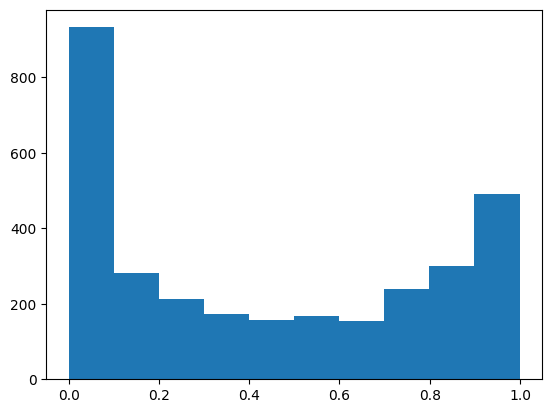

In [20]:
# Calculate distribution probabilities
dist_probs = []
for path in tqdm(paths):
    image = Image.open(path).convert('RGB')
    tensor = transform(image).unsqueeze(0)
    with torch.inference_mode():
        logits = classificator_without_bn(tensor).squeeze(0)
        probs = torch.softmax(logits, 0)
        chicken_prob = probs[chicken_imagenet_class_idx]
        dist_probs.append(chicken_prob)

print(np.mean(dist_probs), np.median(dist_probs))
plt.hist(dist_probs)
plt.show()

In [21]:
# Pruning based on L1 norm
weights = classificator.head.fc.weight
abs_weights = weights.abs()
statistics = abs_weights.sum(dim=0)  # Use L1 norm for pruning
pruned_idxs = statistics.sort()[1][:int(0.25 * len(statistics))]  # Prune 25% of the least important connections

In [22]:
# Create new layers with pruned connections
fc = nn.Linear(in_features=len(pruned_idxs), out_features=1000, bias=True)
fc.weight.data = classificator.head.fc.weight[:, pruned_idxs]

conv = nn.Conv2d(4096, len(pruned_idxs), kernel_size=(1, 1), stride=(1, 1))
conv.weight.data = classificator.pre_logits.fc2.weight[pruned_idxs, :, :, :]
conv.bias.data = classificator.pre_logits.fc2.bias[pruned_idxs]

In [23]:
# Create pruned model
pruned_classificator = create_model('vgg11_bn.tv_in1k', pretrained=True).eval()
pruned_classificator.head.fc = fc
pruned_classificator.pre_logits.fc2 = conv
pruned_classificator = pruned_classificator.eval()

  0%|          | 0/3108 [00:00<?, ?it/s]

0.018962024 0.012102136


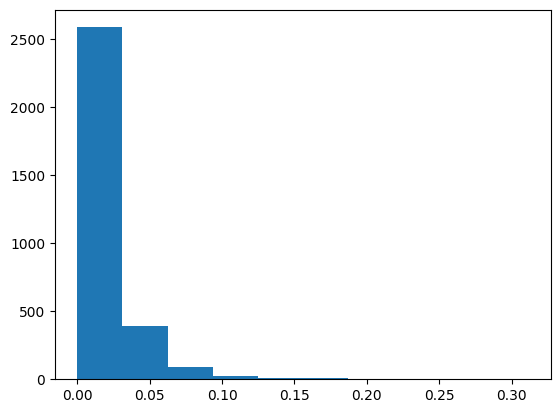

In [28]:
# Calculate distribution probabilities for pruned model
dist_probs = []
for path in tqdm(paths):
    image = Image.open(path).convert('RGB')
    tensor = transform(image).unsqueeze(0)
    with torch.inference_mode():
        logits = pruned_classificator(tensor).squeeze(0)
        probs = torch.softmax(logits, 0)
        chicken_prob = probs[chicken_imagenet_class_idx]
        dist_probs.append(chicken_prob)

print(np.mean(dist_probs), np.median(dist_probs))
plt.hist(dist_probs)
plt.show()

In [29]:
# Print the number of parameters
pruned_params = sum(p.numel() for p in pruned_classificator.parameters())
total_params = sum(p.numel() for p in classificator.parameters())
print(f'{pruned_params / 10**6}*10^6')
print(pruned_params / total_params)

117.210856*10^6
0.8821545819170243
